In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output, display, HTML
from base64 import b64encode
import imageio
from PIL import Image

# from moviepy.editor import *
import cv2
from IPython.display import HTML
import os
import shutil

In [2]:
def get_rays(H: int, W: int, focal: float, c2w: torch.Tensor):
    device = c2w.device
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W, device=device),
        torch.linspace(0, H-1, H, device=device),
        indexing='xy'
    )

    directions = torch.stack([
        (i - W * 0.5) / focal,
        -(j - H * 0.5) / focal,
        -torch.ones_like(i)
    ], dim=-1)

    if c2w.dim() == 3:
        c2w = c2w.squeeze(0)
    rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)
    rays_o = c2w[:3, -1].expand(H, W, 3)

    return rays_o, rays_d

In [3]:
def positional_encoding(x: torch.Tensor, L: int):
    # x shape: [N, 3]
    encodings = [x]

    for l in range(L):
        encodings.append(torch.sin(2**l * x))
        encodings.append(torch.cos(2**l * x))

    return torch.cat(encodings, dim=-1)  # Shape: [N, 3 + 3*2*L]

In [4]:
class NeRF(nn.Module):
    def __init__(self, L: int, width: int = 256):
        super().__init__()
        self.input_dim = 3 + 3*2*L

        # First half of the network with LayerNorm
        self.net = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.input_dim, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(width, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(width, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(width, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            )
        ])

        # Skip connection network with LayerNorm
        self.skip_net = nn.ModuleList([
            nn.Sequential(
                nn.Linear(width + self.input_dim, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(width, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(width, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(width, width),
                # nn.LayerNorm(width),
                nn.ReLU()
            )
        ])

        # Output layer (typically no normalization on final output)
        self.output_layer = nn.Linear(width, 4)

    def forward(self, x):
        input_x = x

        # First half of the network
        for layer in self.net:
            x = layer(x)

        # Skip connection
        x = torch.cat([x, input_x], dim=-1)

        # Second half of the network
        for layer in self.skip_net:
            x = layer(x)

        raw = self.output_layer(x)

        # Scale the outputs
        rgb = raw[..., :3]  # Keep RGB in reasonable range
        sigma = raw[..., 3:] * 1.0  # Increase this multiplier if density is too low

        return torch.cat([rgb, sigma], dim=-1)

In [5]:
def sample_points(rays_o: torch.Tensor, rays_d: torch.Tensor, near: float, far: float,
                 n_samples: int, rand: bool = True):
    device = rays_o.device
    batch_size = rays_o.shape[0]

    # Sample linearly in disparity (inverse depth)
    t = torch.linspace(0., 1., n_samples, device=device)
    z = 1./(1./near * (1.-t) + 1./far * t)

    if rand:
        # Get intervals between samples
        mids = .5 * (z[..., 1:] + z[..., :-1])
        upper = torch.cat([mids, z[..., -1:]], -1)
        lower = torch.cat([z[..., :1], mids], -1)

        # Stratified samples in those intervals
        t_rand = torch.rand(batch_size, n_samples, device=device)
        z = lower.expand(batch_size, n_samples) + \
            (upper - lower).expand(batch_size, n_samples) * t_rand
    else:
        z = z.expand(batch_size, n_samples)

    # Convert depths to points
    points = rays_o[...,None,:] + rays_d[...,None,:] * z[...,:,None]
    return points

In [6]:
def render_rays(nerf: NeRF, points: torch.Tensor, L: int) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size, n_samples, _ = points.shape
    points_flat = points.reshape(-1, 3)
    points_encoded = positional_encoding(points_flat, L)

    raw = nerf(points_encoded)
    raw = raw.reshape(batch_size, n_samples, 4)

    rgb = torch.sigmoid(raw[..., :3])
    sigma = F.relu(raw[..., 3])

    # Get distances between samples
    dists = torch.cat([
        torch.norm(points[:, 1:] - points[:, :-1], dim=-1),
        torch.ones_like(points[:, :1, 0]) * 1e-3
    ], -1)

    # Compute alpha compositing weights
    alpha = 1. - torch.exp(-sigma * dists)
    weights = alpha * torch.cumprod(
        torch.cat([torch.ones_like(alpha[:, :1]), 1. - alpha + 1e-10], -1), -1)[:, :-1]

    rgb_final = torch.sum(weights[..., None] * rgb, -2)
    depth_final = torch.sum(weights * points[..., 2], -1)

    return rgb_final, depth_final

In [7]:
def train_nerf(nerf: NeRF, images: torch.Tensor, poses: torch.Tensor, focal: float,
               n_samples: int = 64, num_iters: int = 10000,
               batch_size: int = 1024, lr: float = 5e-4, near: float = 2., far: float = 6.,
               L: int = 6, device: str = 'cuda', test_img=None, test_pose=None):
    optimizer = optim.Adam(nerf.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                            milestones=[2000, 4000, 6000, 8000],
                                            gamma=0.5)
    H, W = images.shape[1:3]
    losses = []
    best_psnrs = []
    test_every = 100
    best_psnr = 0

    def compute_combined_loss(pred, target):
        mse = F.mse_loss(pred, target)
        psnr = -10 * torch.log10(mse)
        # Normalize PSNR to similar scale as MSE
        # Typical good PSNR is around 30-40, so we scale it down
        psnr_loss = (50 - psnr) / 50  # This maps PSNR of 50 to 0 loss, 0 to 1 loss
        # Combine losses with weights
        return mse + 0.1 * psnr_loss, mse, psnr

    with tqdm(total=num_iters, desc='Training NeRF') as pbar:
        for i in range(num_iters):
            # Random image
            img_idx = torch.randint(0, len(images), (1,))
            target = images[img_idx].to(device)
            pose = poses[img_idx].to(device)

            # Get rays
            rays_o, rays_d = get_rays(H, W, focal, pose)
            rays_o = rays_o.reshape(-1, 3)
            rays_d = rays_d.reshape(-1, 3)
            target = target.reshape(-1, 3)

            # Random ray batch
            select_idx = torch.randint(0, H * W, (batch_size,), device=device)
            rays_o = rays_o[select_idx].to(device)
            rays_d = rays_d[select_idx].to(device)
            target = target[select_idx].to(device)

            # Sample points with stratified sampling
            points = sample_points(rays_o, rays_d, near, far, n_samples, True)

            # Render
            rgb, depth = render_rays(nerf, points, L)

            # Compute combined loss
            combined_loss, mse_loss, psnr = compute_combined_loss(rgb, target)

            # Optimize
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()
            scheduler.step()

            losses.append(combined_loss.item())

            # Update tqdm
            pbar.set_postfix(
                loss=f'{combined_loss.item():.4f}',
                mse=f'{mse_loss.item():.4f}',
                psnr=f'{psnr.item():.2f}',
                lr=f'{scheduler.get_last_lr()[0]:.6f}'
            )
            pbar.update(1)

            if i % test_every == 0:
                with torch.no_grad():
                    if test_img is not None and test_pose is not None:
                        test_psnr = test_view(nerf, test_img, test_pose, H, W, focal, near, far, n_samples, L, device)
                        if test_psnr > best_psnr:
                            best_psnr = test_psnr
                        best_psnrs.append(best_psnr)
                        pbar.write(f'Test PSNR: {test_psnr:.2f} (Best: {best_psnr:.2f})')

    return losses, best_psnrs

# Add test function
def test_view(nerf, test_img, test_pose, H, W, focal, near, far, n_samples, L, device):
    test_pose = test_pose.to(device)
    test_img = test_img.to(device)

    rays_o, rays_d = get_rays(H, W, focal, test_pose)
    rays_o = rays_o.to(device).reshape(-1, 3)
    rays_d = rays_d.to(device).reshape(-1, 3)

    rgb_pred = []
    for i in range(0, rays_o.shape[0], 4096):  # Process in chunks to avoid OOM
        points = sample_points(rays_o[i:i+4096], rays_d[i:i+4096], near, far, n_samples, False)
        rgb_chunk, _ = render_rays(nerf, points, L)
        rgb_pred.append(rgb_chunk)

    rgb_pred = torch.cat(rgb_pred, 0).reshape(H, W, 3)
    test_loss = F.mse_loss(rgb_pred, test_img[...,:3])
    test_psnr = -10 * torch.log10(test_loss)

    return test_psnr.item()

In [8]:
# Load data

npz_file_name = '/kaggle/input/nerf-datasets/elephant_100.npz'
# npz_file_name = '/kaggle/input/house-200/house_200.npz'

data = np.load(npz_file_name)
images = torch.from_numpy(data['images'][:130]).float()
images = torch.flip(images, dims=[1])
poses = torch.from_numpy(data['poses'][:130]).float()
focal = data['focal'][0]
print(focal)
# focal = 150
# focal = torch.ones((1, 100)).float().cuda()

138.88889188714614


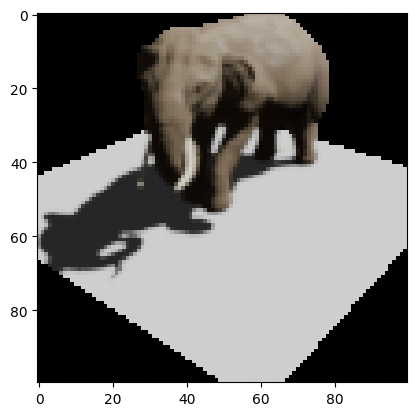

In [9]:
display_img = images[129].numpy()
plt.imshow(display_img)
plt.show()

In [11]:
## Test image/pose
test_img = torch.from_numpy(data['images'][131]).float()
test_pose = torch.from_numpy(data['poses'][131]).float()

In [24]:
# At the start of training:
# Normalize images to [0, 1] if not already
images = images / 255. if images.max() > 1 else images
test_img = test_img / 255. if test_img.max() > 1 else test_img

# Ensure everything is on the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
images = images.to(device)
poses = poses.to(device)
test_img = test_img.to(device)
test_pose = test_pose.to(device)

Training NeRF: 100%|██████████| 2000/2000 [00:55<00:00, 35.83it/s, loss=0.0626, lr=0.000250, mse=0.0064, psnr=21.92]


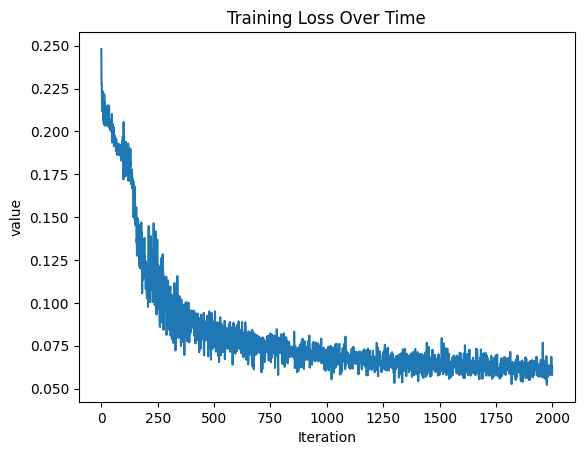

In [41]:
# Initialize model and train
L = 8
width = 128
nerf = NeRF(L=L, width=width).to(device)

# Usage:
losses, best_psnrs = train_nerf(nerf, images, poses, focal, device=device, num_iters=2000, L=L)

# You can then plot the losses:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(best_psnrs)
plt.xlabel('Iteration')
plt.ylabel('value')
plt.title('Training Loss Over Time')
plt.show()

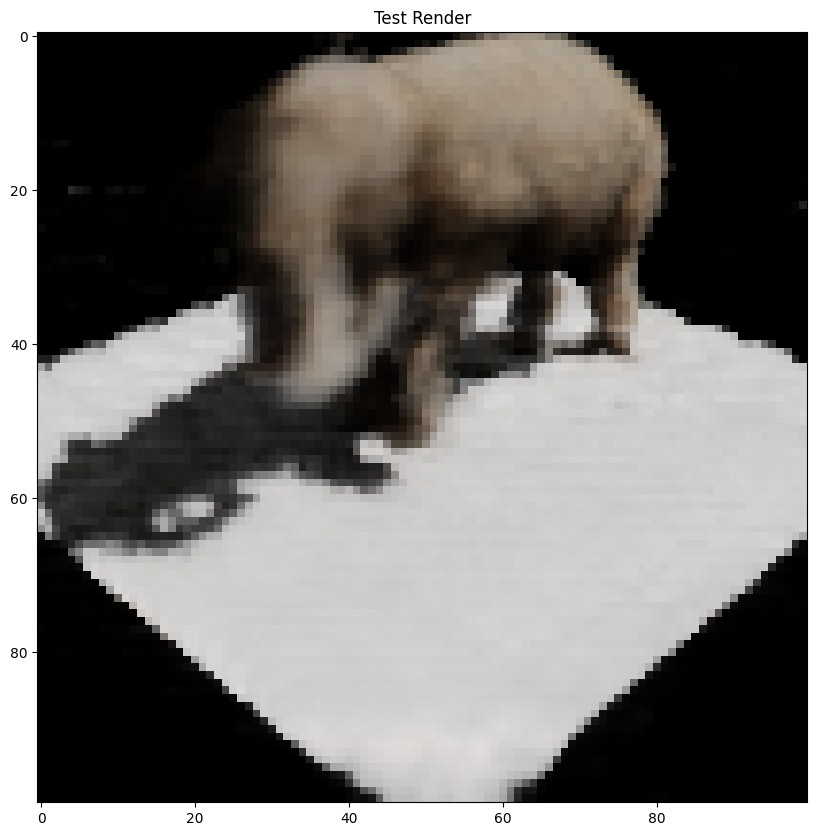

In [42]:
def test_render(nerf, test_img, test_pose, H, W, focal, device):
    with torch.no_grad():
        test_pose = test_pose.to(device)
        rays_o, rays_d = get_rays(H, W, focal, test_pose)
        rays_o = rays_o.to(device).reshape(-1, 3)
        rays_d = rays_d.to(device).reshape(-1, 3)

        rgb_pred = []
        chunk_size = 256  # Smaller chunks for higher resolution

        # with torch.cuda.amp.autocast():
        for i in range(0, rays_o.shape[0], chunk_size):
            points = sample_points(
                rays_o[i:i+chunk_size],
                rays_d[i:i+chunk_size],
                near=2., far=6., n_samples=32,
                rand=False
            )
            rgb_chunk, _ = render_rays(nerf, points, L)
            rgb_pred.append(rgb_chunk.cpu())
            torch.cuda.empty_cache()

        rgb = torch.cat(rgb_pred, 0).reshape(H, W, 3)

        plt.figure(figsize=(10, 10))
        plt.imshow(rgb.numpy())
        plt.title('Test Render')
        plt.show()

        return rgb

test_rgb = test_render(nerf, test_img, test_pose, 100, 100, focal, device)

In [16]:
def render_frames(nerf, H, W, focal, near=2., far=6., n_samples=64, L=36, radius=3.0, phi=-30, device='cuda', output_dir='nerf_frames', display_interval=10):
    """
    Render frames using the trained NeRF model with correct horizontal rotation and Blender-style phi
    """
    import cv2
    import os
    from IPython.display import clear_output, HTML
    from base64 import b64encode
    
    def create_360_poses(radius=3.0, theta_range=(0, 360), phi=-30):
        """Create camera poses for horizontal rotation around object"""
        def pose_spherical(theta, phi, radius):
            theta_rad = theta/180.*np.pi
            phi_rad = phi/180.*np.pi

            x = radius * np.cos(-phi_rad) * np.cos(theta_rad)
            y = radius * np.sin(-phi_rad)
            z = radius * np.cos(-phi_rad) * np.sin(theta_rad)

            from_pos = np.array([x, y, z])
            to_pos = np.array([0, 0, 0])
            forward = - to_pos + from_pos
            forward = forward / np.linalg.norm(forward)

            right = np.cross(np.array([0, 1, 0]), forward)
            right = right / np.linalg.norm(right)
            up = np.cross(forward, right)

            c2w = np.stack([right, up, -forward, from_pos], axis=1)
            c2w = np.concatenate([c2w, np.array([[0, 0, 0, 1]])], axis=0)

            return torch.tensor(c2w, dtype=torch.float32)

        n_frames = 120
        poses = []
        thetas = np.linspace(theta_range[0], theta_range[1], n_frames, endpoint=False)

        for theta in thetas:
            poses.append(pose_spherical(theta, phi, radius))

        return torch.stack(poses)

    os.makedirs(output_dir, exist_ok=True)
    poses = create_360_poses(radius=radius, phi=phi).to(device)
    frames = []

    # Render frames
    with torch.no_grad():
        for i, pose in enumerate(tqdm(poses, desc="Rendering frames")):
            rays_o, rays_d = get_rays(H, W, focal, pose)
            rays_o = rays_o.reshape(-1, 3)
            rays_d = rays_d.reshape(-1, 3)
            rgb_chunks = []

            for j in range(0, rays_o.shape[0], 4096):
                points = sample_points(
                    rays_o[j:j+4096],
                    rays_d[j:j+4096],
                    near, far, n_samples, False
                )
                rgb_chunk, _ = render_rays(nerf, points, L)
                rgb_chunks.append(rgb_chunk)

            rgb = torch.cat(rgb_chunks, 0).reshape(H, W, 3)
            frame = (rgb.cpu().numpy() * 255).astype(np.uint8)
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            frames.append(frame_bgr)

            if display_interval and i % display_interval == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 10))
                plt.imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title(f'Frame {i}/{len(poses)}')
                plt.show()

    try:
        # Try different codecs in order of preference
        codecs = [
            ('mp4v', '.mp4'),
            ('XVID', '.avi'),
            ('MJPG', '.avi'),
            ('X264', '.mp4')
        ]
        
        success = False
        video_path = None
        
        for codec, ext in codecs:
            try:
                base_name = os.path.splitext(os.path.basename(npz_file_name))[0]
                video_filename = f'{base_name}_phi_{-phi}{ext}'
                video_path = os.path.join(output_dir, video_filename)
                
                fourcc = cv2.VideoWriter_fourcc(*codec)
                out = cv2.VideoWriter(video_path, fourcc, 30.0, (W, H))
                
                if out.isOpened():
                    # Write frames
                    for frame in frames:
                        out.write(frame)
                    out.release()
                    success = True
                    print(f"Successfully created video with codec {codec}")
                    break
                else:
                    out.release()
                    if os.path.exists(video_path):
                        os.remove(video_path)
            except Exception as e:
                print(f"Failed with codec {codec}: {str(e)}")
                if out is not None:
                    out.release()
                if video_path and os.path.exists(video_path):
                    os.remove(video_path)
                continue
        
        if not success:
            raise Exception("All codec attempts failed")
            
        # Try to display the video if it was created
        if video_path and os.path.exists(video_path):
            with open(video_path, 'rb') as f:
                video_data = f.read()
                video_encoded = b64encode(video_data).decode('utf-8')
                
                display(HTML(f"""
                <video width="100%" height="auto" controls>
                    <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
                    Your browser does not support the video tag.
                </video>
                """))

    except Exception as e:
        print(f"Error creating video: {e}")
        # As a fallback, save individual frames as images
        print("Saving individual frames as fallback...")
        frames_dir = os.path.join(output_dir, f'frames_phi_{-phi}')
        os.makedirs(frames_dir, exist_ok=True)
        for i, frame in enumerate(frames):
            frame_path = os.path.join(frames_dir, f'frame_{i:03d}.png')
            cv2.imwrite(frame_path, frame)
        print(f"Saved {len(frames)} frames to {frames_dir}")

    return frames

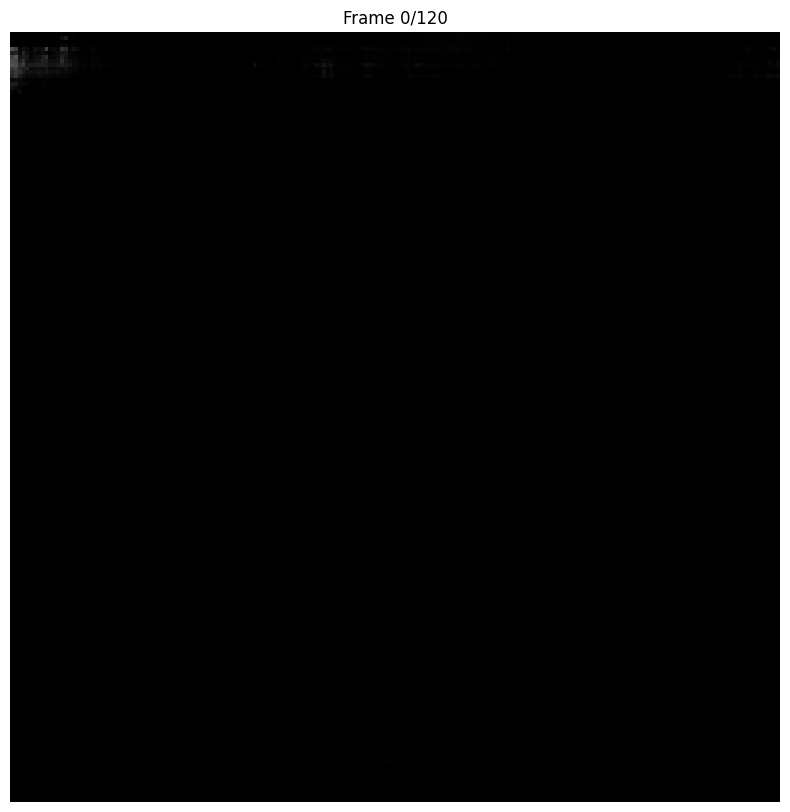

Rendering frames:   6%|▌         | 7/120 [00:35<09:36,  5.11s/it]


KeyboardInterrupt: 

In [20]:
# First let's get just the base name of the file without the full path or extension
base_name = os.path.splitext(os.path.basename(npz_file_name))[0]

# frames_list = [render_frames(
#     nerf=nerf,
#     H=200,
#     W=200,
#     L=L,
#     phi=-angle * 10,
#     focal=focal,
#     device='cuda',
#     output_dir=f'{base_name}_rendered_frames') for angle in range(7)
# ]
render_frames(
    nerf=nerf,
    H=200,
    W=200,
    L=L,
    phi=-30,
    focal=focal,
    device='cuda',
    output_dir=f'{base_name}_rendered_frames')

In [1]:
# Get all MP4 files from the directory
mp4_files = [f for f in os.listdir(f'{base_name}_rendered_frames') if f.endswith('.mp4')]

# Create HTML for each video
video_elements = []
for mp4_file in mp4_files:
    with open(os.path.join(f'{base_name}_rendered_frames', mp4_file), 'rb') as f:
        video_data = f.read()
    video_encoded = b64encode(video_data).decode('utf-8')

    video_elements.append(f"""
    <div style="margin: 20px 0;">
        <h3>{mp4_file}</h3>
        <video width="100%" height="auto" controls autoplay loop muted>
            <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
    """)

# Combine all videos into one HTML display
HTML("""
<div style="display: flex; flex-direction: column; gap: 20px;">
    {}
</div>
""".format('\n'.join(video_elements)))

# Create a zip file containing all files from rendered_frames
shutil.make_archive(f'{base_name}_rendered_frames', 'zip', f'{base_name}_rendered_frames')

print(f"Created {base_name}_rendered_frames_archive.zip")

NameError: name 'os' is not defined